# Degree-Conditioned Compositionality Analysis

## Research Questions

1. **Is compositionality degree-dependent?** Does PMI vary systematically with node degrees?
2. **Are null (permuted) metapaths compositional?** Do degree-preserving permutations preserve or break compositionality?

## Key Findings from Notebook 10

- **Hetionet CbGpPW**: Mean PMI = 7.11 (strongly conditional)
- **Correlation**: r = 0.057 (compositional model fails)

## New Analysis

We now test:
1. Whether PMI depends on node degrees (compound degree, pathway degree)
2. Whether permuted networks show the same conditional structure
3. If degree structure alone explains the conditional dependencies

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd().parent
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
results_dir = repo_dir / 'results'

sys.path.append(str(src_dir))

print(f"Repository: {repo_dir}")

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Repository: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability


## Configuration

In [2]:
# Test metapath: CbGpPW
metapath = ['CbG', 'GpPW']
metapath_name = 'CbGpPW'

# Permutations to analyze
PERMUTATION_IDS = list(range(1, 21))  # Permutations 001-020 (null networks)
HETIONET_ID = 0  # Permutation 000 (real network)

# Degree bins for stratification
DEGREE_BINS = [0, 5, 20, 100, np.inf]
DEGREE_LABELS = ['Very Low (0-5)', 'Low (5-20)', 'Medium (20-100)', 'High (>100)']

print(f"Testing metapath: {metapath_name}")
print(f"  Edge 1: {metapath[0]} (Compound → Gene)")
print(f"  Edge 2: {metapath[1]} (Gene → Pathway)")
print(f"\nAnalyzing {len(PERMUTATION_IDS)} permutations: {PERMUTATION_IDS[0]:03d} - {PERMUTATION_IDS[-1]:03d}")
print(f"Hetionet (real): {HETIONET_ID:03d}")

Testing metapath: CbGpPW
  Edge 1: CbG (Compound → Gene)
  Edge 2: GpPW (Gene → Pathway)

Analyzing 20 permutations: 001 - 020
Hetionet (real): 000


## Helper Functions

In [3]:
def load_edge_matrix(edge_type: str, perm_id: int = 0) -> sp.csr_matrix:
    """Load edge matrix for given edge type and permutation."""
    edge_file = data_dir / 'permutations' / f'{perm_id:03d}.hetmat' / 'edges' / f'{edge_type}.sparse.npz'
    return sp.load_npz(edge_file)

def analytical_prior(u: float, v: float, m: float) -> float:
    """Current analytical formula for edge probability."""
    uv = u * v
    denominator = np.sqrt(uv**2 + (m - u - v + 1)**2)
    return uv / denominator if denominator > 0 else 0.0

def compute_metapath_compositionality(edge1_matrix: sp.csr_matrix, edge2_matrix: sp.csr_matrix, 
                                      perm_id: int) -> pd.DataFrame:
    """
    Compute compositionality analysis for a metapath in a given permutation.
    
    Returns DataFrame with columns:
    - compound_idx, pathway_idx
    - compound_degree, pathway_degree
    - observed_freq, compositional_prob, pmi, residual
    - perm_id
    """
    # Filter zero-degree nodes
    compound_degrees = np.array(edge1_matrix.sum(axis=1)).flatten()
    pathway_degrees = np.array(edge2_matrix.sum(axis=0)).flatten()
    
    compound_nonzero = np.where(compound_degrees > 0)[0]
    pathway_nonzero = np.where(pathway_degrees > 0)[0]
    
    edge1_aligned = edge1_matrix[compound_nonzero, :]
    edge2_aligned = edge2_matrix[:, pathway_nonzero]
    
    # Get aligned degrees
    compound_degrees_aligned = compound_degrees[compound_nonzero]
    pathway_degrees_aligned = pathway_degrees[pathway_nonzero]
    
    # Compute metapath matrix
    metapath_matrix = edge1_aligned @ edge2_aligned
    
    # Compute observed frequencies
    observed_freq = {}
    for i, j in zip(*metapath_matrix.nonzero()):
        compound_genes = edge1_aligned.getrow(i).nonzero()[1]
        pathway_genes = edge2_aligned.getcol(j).nonzero()[0]
        shared_genes = set(compound_genes) & set(pathway_genes)
        n_paths = len(shared_genes)
        n_possible = len(compound_genes)
        if n_possible > 0:
            observed_freq[(i, j)] = n_paths / n_possible
    
    # Compute edge priors (analytical formula)
    m1 = edge1_aligned.nnz
    m2 = edge2_aligned.nnz
    
    gene_degrees_1 = np.array(edge1_aligned.sum(axis=0)).flatten()
    gene_degrees_2 = np.array(edge2_aligned.sum(axis=1)).flatten()
    
    edge1_priors = {}
    rows1, cols1 = edge1_aligned.nonzero()
    for i, j in zip(rows1, cols1):
        u, v = compound_degrees_aligned[i], gene_degrees_1[j]
        if u > 0 and v > 0:
            edge1_priors[(i, j)] = analytical_prior(u, v, m1)
    
    edge2_priors = {}
    rows2, cols2 = edge2_aligned.nonzero()
    for i, j in zip(rows2, cols2):
        u, v = gene_degrees_2[i], pathway_degrees_aligned[j]
        if u > 0 and v > 0:
            edge2_priors[(i, j)] = analytical_prior(u, v, m2)
    
    # Compute compositional probabilities
    compositional_prob = {}
    for i in range(len(compound_nonzero)):
        compound_genes = edge1_aligned.getrow(i).nonzero()[1]
        for j in range(len(pathway_nonzero)):
            pathway_genes = edge2_aligned.getcol(j).nonzero()[0]
            total_prob = 0.0
            for gene in set(compound_genes) & set(pathway_genes):
                p_edge1 = edge1_priors.get((i, gene), 0.0)
                p_edge2 = edge2_priors.get((gene, j), 0.0)
                total_prob += p_edge1 * p_edge2
            if total_prob > 0:
                compositional_prob[(i, j)] = total_prob
    
    # Compute PMI
    results = []
    common_pairs = set(observed_freq.keys()) & set(compositional_prob.keys())
    
    for i, j in common_pairs:
        p_obs = observed_freq[(i, j)]
        p_comp = compositional_prob[(i, j)]
        
        if p_obs > 0 and p_comp > 0:
            pmi = np.log2(p_obs / p_comp)
            residual = p_obs - p_comp
            
            results.append({
                'perm_id': perm_id,
                'compound_idx': i,
                'pathway_idx': j,
                'compound_degree': int(compound_degrees_aligned[i]),
                'pathway_degree': int(pathway_degrees_aligned[j]),
                'observed_freq': p_obs,
                'compositional_prob': p_comp,
                'pmi': pmi,
                'residual': residual
            })
    
    return pd.DataFrame(results)

def bin_degrees(df: pd.DataFrame, bins=DEGREE_BINS, labels=DEGREE_LABELS):
    """Add degree bin columns to DataFrame."""
    df['compound_degree_bin'] = pd.cut(df['compound_degree'], bins=bins, labels=labels)
    df['pathway_degree_bin'] = pd.cut(df['pathway_degree'], bins=bins, labels=labels)
    return df

## Part 1: Degree-Stratified Analysis of Hetionet

In [4]:
print("Analyzing Hetionet (permutation 000)...\n")

edge1_het = load_edge_matrix(metapath[0], HETIONET_ID)
edge2_het = load_edge_matrix(metapath[1], HETIONET_ID)

hetionet_results = compute_metapath_compositionality(edge1_het, edge2_het, HETIONET_ID)
hetionet_results = bin_degrees(hetionet_results)

print(f"Hetionet results: {len(hetionet_results)} metapath pairs")
print(f"\nOverall PMI statistics:")
print(f"  Mean: {hetionet_results['pmi'].mean():.4f}")
print(f"  Median: {hetionet_results['pmi'].median():.4f}")
print(f"  Std: {hetionet_results['pmi'].std():.4f}")

Analyzing Hetionet (permutation 000)...

Hetionet results: 122728 metapath pairs

Overall PMI statistics:
  Mean: 7.1106
  Median: 6.9127
  Std: 3.6863


In [5]:
# PMI stratified by compound degree
print("\nPMI by Compound Degree:")
print(hetionet_results.groupby('compound_degree_bin')['pmi'].agg(['count', 'mean', 'std']))

print("\nPMI by Pathway Degree:")
print(hetionet_results.groupby('pathway_degree_bin')['pmi'].agg(['count', 'mean', 'std']))


PMI by Compound Degree:
                     count       mean       std
compound_degree_bin                            
Very Low (0-5)       24981  10.007043  3.491365
Low (5-20)           65210   7.160227  3.241036
Medium (20-100)      31083   4.910953  2.966661
High (>100)           1454   2.143525  2.441404

PMI by Pathway Degree:
                    count       mean       std
pathway_degree_bin                            
Very Low (0-5)       1792  10.989036  3.420308
Low (5-20)          10877   9.794228  3.353197
Medium (20-100)     62152   7.676748  3.400027
High (>100)         47907   5.621700  3.463160


## Part 2: Compositionality Across Permutations

In [6]:
print(f"Analyzing {len(PERMUTATION_IDS)} permutations...\n")

all_perm_results = []

for perm_id in tqdm(PERMUTATION_IDS, desc="Processing permutations"):
    edge1 = load_edge_matrix(metapath[0], perm_id)
    edge2 = load_edge_matrix(metapath[1], perm_id)
    
    perm_results = compute_metapath_compositionality(edge1, edge2, perm_id)
    perm_results = bin_degrees(perm_results)
    
    all_perm_results.append(perm_results)

# Combine all permutation results
perm_df = pd.concat(all_perm_results, ignore_index=True)

print(f"\nTotal permutation results: {len(perm_df)} metapath pairs across {len(PERMUTATION_IDS)} permutations")
print(f"Average per permutation: {len(perm_df) / len(PERMUTATION_IDS):.0f} pairs")

Analyzing 20 permutations...



Processing permutations: 100%|██████████| 20/20 [26:07<00:00, 78.39s/it]


Total permutation results: 2464932 metapath pairs across 20 permutations
Average per permutation: 123247 pairs


In [7]:
# Summary statistics per permutation
perm_summary = perm_df.groupby('perm_id')['pmi'].agg(['mean', 'median', 'std', 'count']).reset_index()

print("\nPMI Summary by Permutation:")
print(perm_summary)

print(f"\nOverall Null Distribution (across all permutations):")
print(f"  Mean PMI: {perm_df['pmi'].mean():.4f}")
print(f"  Median PMI: {perm_df['pmi'].median():.4f}")
print(f"  Std PMI: {perm_df['pmi'].std():.4f}")


PMI Summary by Permutation:
    perm_id      mean    median       std   count
0         1  7.094695  6.830396  3.738601  123288
1         2  7.134113  6.904429  3.715314  123600
2         3  7.213165  6.961909  3.695203  123513
3         4  7.100154  6.798901  3.726995  123781
4         5  7.121047  6.877990  3.840808  121777
5         6  7.137842  6.881357  3.780430  122869
6         7  7.146330  6.888930  3.672562  124321
7         8  7.067478  6.780046  3.726119  123375
8         9  7.154049  6.893286  3.667737  124339
9        10  7.123805  6.880588  3.677235  123044
10       11  7.183906  6.965704  3.764402  123309
11       12  7.148642  6.873209  3.661960  124921
12       13  7.096167  6.876930  3.792791  121965
13       14  7.104970  6.849184  3.759677  123039
14       15  7.156585  6.885074  3.688414  123657
15       16  7.074251  6.793546  3.723309  123171
16       17  7.143118  6.895354  3.718414  123523
17       18  7.165920  6.905363  3.732750  122299
18       19  7.144436

## Part 3: Hetionet vs Null Comparison

In [8]:
# Statistical comparison
from scipy.stats import mannwhitneyu, ttest_ind

het_pmi = hetionet_results['pmi'].values
null_pmi = perm_df['pmi'].values

# Mann-Whitney U test (non-parametric)
u_stat, u_pval = mannwhitneyu(het_pmi, null_pmi, alternative='two-sided')

# T-test (parametric)
t_stat, t_pval = ttest_ind(het_pmi, null_pmi)

print("="*80)
print("HETIONET vs NULL DISTRIBUTION COMPARISON")
print("="*80)

print(f"\nHetionet (n={len(het_pmi)}):")
print(f"  Mean PMI: {het_pmi.mean():.4f}")
print(f"  Median PMI: {np.median(het_pmi):.4f}")

print(f"\nNull Distribution (n={len(null_pmi)}):")
print(f"  Mean PMI: {null_pmi.mean():.4f}")
print(f"  Median PMI: {np.median(null_pmi):.4f}")

print(f"\nStatistical Tests:")
print(f"  Mann-Whitney U: U={u_stat:.2e}, p={u_pval:.2e}")
print(f"  T-test: t={t_stat:.4f}, p={t_pval:.2e}")

print(f"\nEffect Size:")
print(f"  Difference in means: {het_pmi.mean() - null_pmi.mean():.4f}")
print(f"  Cohen's d: {(het_pmi.mean() - null_pmi.mean()) / np.sqrt((het_pmi.std()**2 + null_pmi.std()**2) / 2):.4f}")

# Interpretation
print(f"\nInterpretation:")
if u_pval < 0.001:
    if het_pmi.mean() > null_pmi.mean():
        print(f"  ✓ HETIONET IS SIGNIFICANTLY MORE CONDITIONAL (p < 0.001)")
        print(f"    → Real biological dependencies create conditional structure")
        print(f"    → Degree-preserving randomization BREAKS biological dependencies")
    else:
        print(f"  ✓ NULL IS MORE CONDITIONAL (p < 0.001)")
        print(f"    → Degree structure alone creates conditional dependencies")
else:
    print(f"  → NO SIGNIFICANT DIFFERENCE (p = {u_pval:.3f})")
    print(f"    → Conditional structure is mathematical consequence of degrees")

HETIONET vs NULL DISTRIBUTION COMPARISON

Hetionet (n=122728):
  Mean PMI: 7.1106
  Median PMI: 6.9127

Null Distribution (n=2464932):
  Mean PMI: 7.1331
  Median PMI: 6.8758

Statistical Tests:
  Mann-Whitney U: U=1.51e+11, p=7.15e-01
  T-test: t=-2.0639, p=3.90e-02

Effect Size:
  Difference in means: -0.0225
  Cohen's d: -0.0061

Interpretation:
  → NO SIGNIFICANT DIFFERENCE (p = 0.715)
    → Conditional structure is mathematical consequence of degrees


## Degree-Stratified Comparison

In [9]:
# Compare PMI distributions by degree bins
print("\nDegree-Stratified Comparison:\n")

for degree_col in ['compound_degree_bin', 'pathway_degree_bin']:
    print(f"\nBy {degree_col}:")
    print("-" * 60)
    
    for bin_label in DEGREE_LABELS:
        het_subset = hetionet_results[hetionet_results[degree_col] == bin_label]['pmi']
        null_subset = perm_df[perm_df[degree_col] == bin_label]['pmi']
        
        if len(het_subset) > 0 and len(null_subset) > 0:
            u_stat, u_pval = mannwhitneyu(het_subset, null_subset, alternative='two-sided')
            
            print(f"\n  {bin_label}:")
            print(f"    Hetionet: mean={het_subset.mean():.4f}, n={len(het_subset)}")
            print(f"    Null:     mean={null_subset.mean():.4f}, n={len(null_subset)}")
            print(f"    Difference: {het_subset.mean() - null_subset.mean():.4f}")
            print(f"    p-value: {u_pval:.2e}")


Degree-Stratified Comparison:


By compound_degree_bin:
------------------------------------------------------------

  Very Low (0-5):
    Hetionet: mean=10.0070, n=24981
    Null:     mean=10.2256, n=507751
    Difference: -0.2186
    p-value: 9.61e-25

  Low (5-20):
    Hetionet: mean=7.1602, n=65210
    Null:     mean=7.1243, n=1295061
    Difference: 0.0360
    p-value: 3.03e-04

  Medium (20-100):
    Hetionet: mean=4.9110, n=31083
    Null:     mean=4.8909, n=634721
    Difference: 0.0201
    p-value: 1.15e-01

  High (>100):
    Hetionet: mean=2.1435, n=1454
    Null:     mean=2.1812, n=27399
    Difference: -0.0377
    p-value: 5.23e-01

By pathway_degree_bin:
------------------------------------------------------------

  Very Low (0-5):
    Hetionet: mean=10.9890, n=1792
    Null:     mean=11.3284, n=32513
    Difference: -0.3393
    p-value: 5.18e-06

  Low (5-20):
    Hetionet: mean=9.7942, n=10877
    Null:     mean=9.6664, n=243238
    Difference: 0.1278
    p-value: 1.

## Visualizations

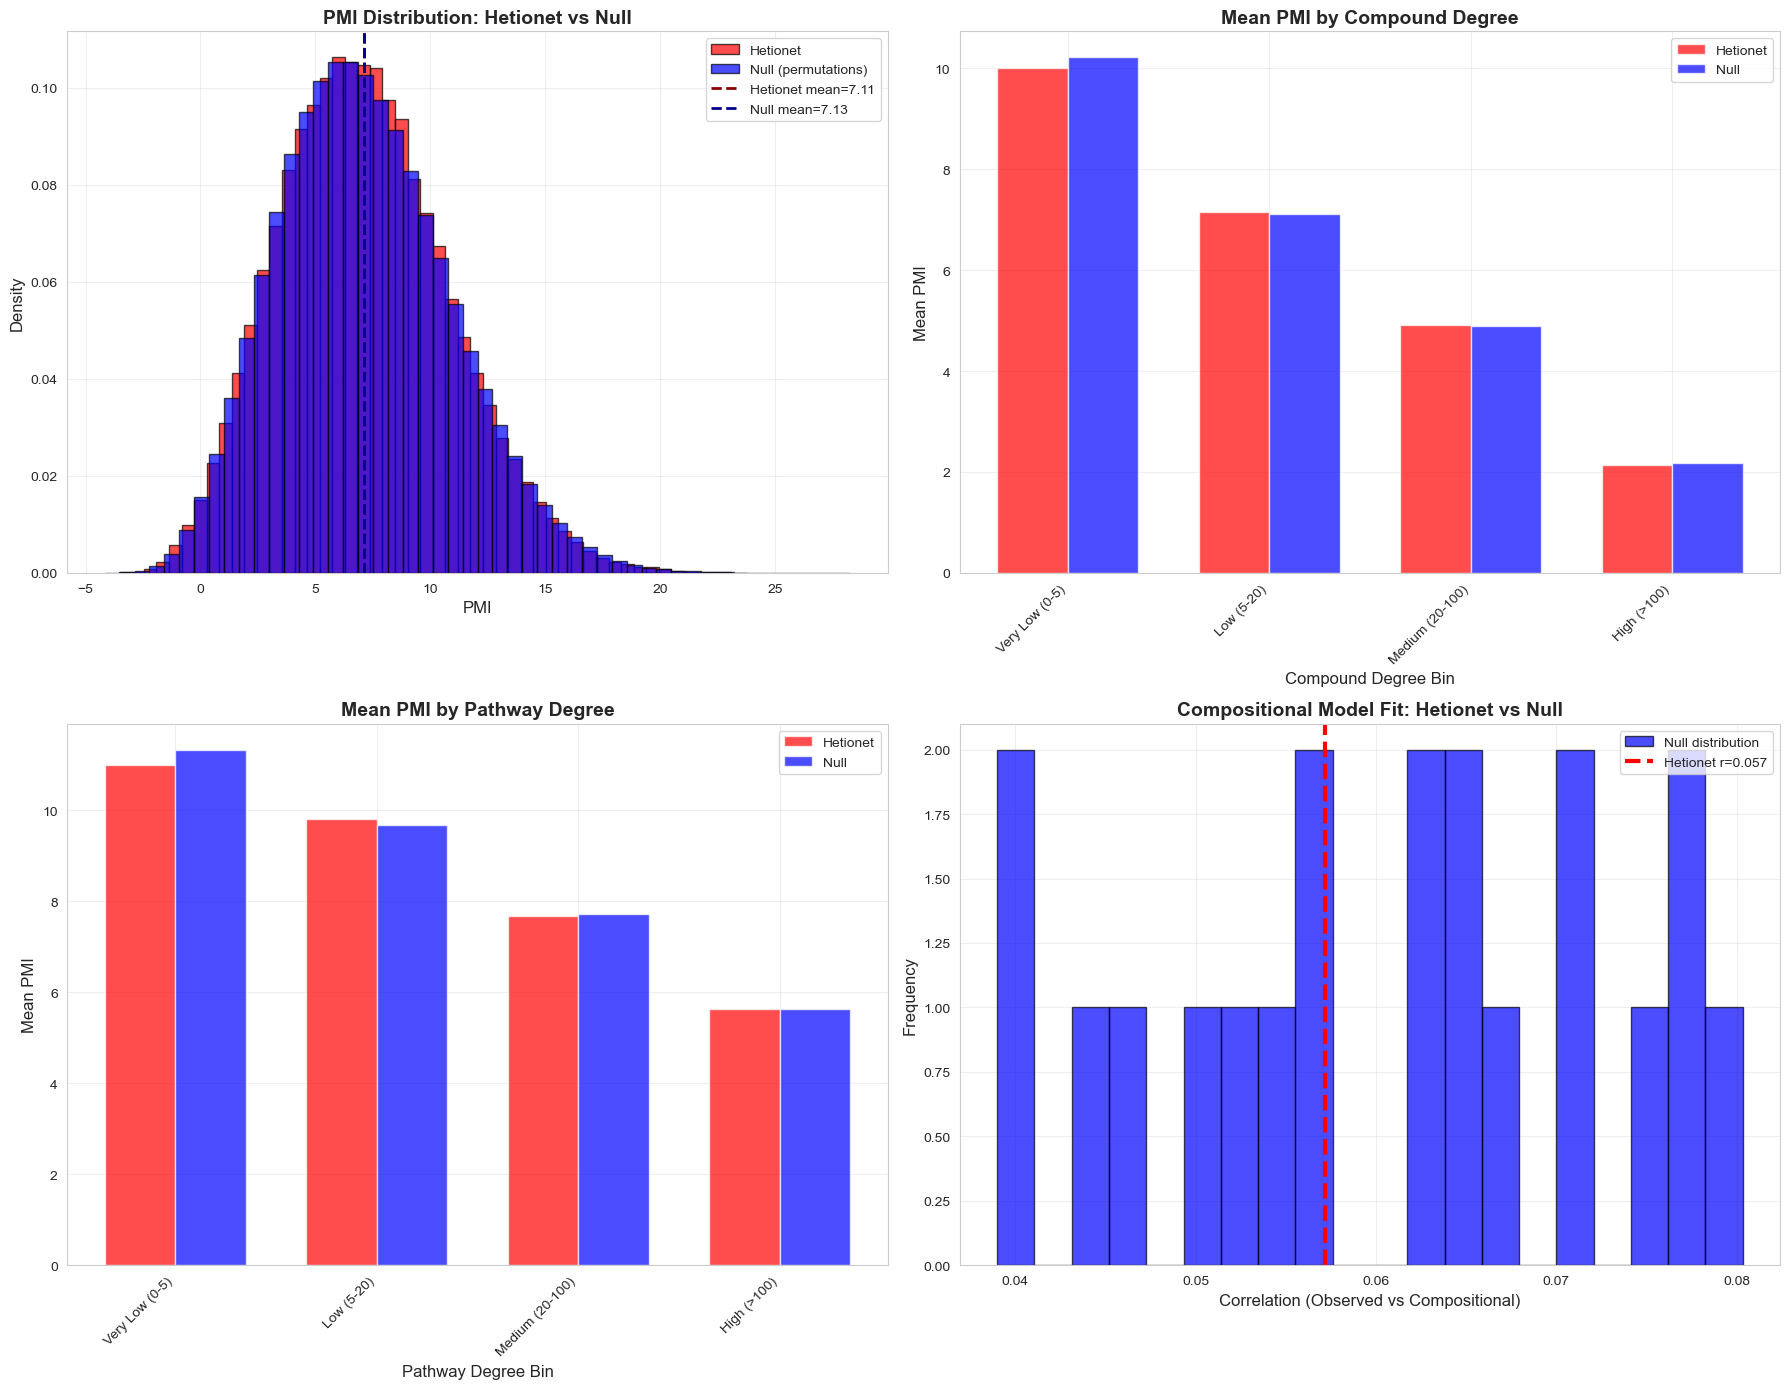


Saved plot to: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/metapath_CbGpPW_degree_conditioned_analysis.png


In [10]:
# Plot 1: PMI distributions - Hetionet vs Null
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Overall PMI distribution
ax = axes[0, 0]
ax.hist(het_pmi, bins=50, alpha=0.7, label='Hetionet', color='red', density=True, edgecolor='black')
ax.hist(null_pmi, bins=50, alpha=0.7, label='Null (permutations)', color='blue', density=True, edgecolor='black')
ax.axvline(het_pmi.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Hetionet mean={het_pmi.mean():.2f}')
ax.axvline(null_pmi.mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Null mean={null_pmi.mean():.2f}')
ax.set_xlabel('PMI', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('PMI Distribution: Hetionet vs Null', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# PMI by compound degree
ax = axes[0, 1]
het_grouped = hetionet_results.groupby('compound_degree_bin')['pmi'].mean()
null_grouped = perm_df.groupby('compound_degree_bin')['pmi'].mean()
x = np.arange(len(DEGREE_LABELS))
width = 0.35
ax.bar(x - width/2, het_grouped.reindex(DEGREE_LABELS, fill_value=0), width, label='Hetionet', color='red', alpha=0.7)
ax.bar(x + width/2, null_grouped.reindex(DEGREE_LABELS, fill_value=0), width, label='Null', color='blue', alpha=0.7)
ax.set_xlabel('Compound Degree Bin', fontsize=12)
ax.set_ylabel('Mean PMI', fontsize=12)
ax.set_title('Mean PMI by Compound Degree', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(DEGREE_LABELS, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3)

# PMI by pathway degree
ax = axes[1, 0]
het_grouped = hetionet_results.groupby('pathway_degree_bin')['pmi'].mean()
null_grouped = perm_df.groupby('pathway_degree_bin')['pmi'].mean()
ax.bar(x - width/2, het_grouped.reindex(DEGREE_LABELS, fill_value=0), width, label='Hetionet', color='red', alpha=0.7)
ax.bar(x + width/2, null_grouped.reindex(DEGREE_LABELS, fill_value=0), width, label='Null', color='blue', alpha=0.7)
ax.set_xlabel('Pathway Degree Bin', fontsize=12)
ax.set_ylabel('Mean PMI', fontsize=12)
ax.set_title('Mean PMI by Pathway Degree', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(DEGREE_LABELS, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3)

# Correlation: observed vs compositional
ax = axes[1, 1]
het_corr = pearsonr(hetionet_results['observed_freq'], hetionet_results['compositional_prob'])[0]
null_corrs = []
for perm_id in PERMUTATION_IDS:
    perm_subset = perm_df[perm_df['perm_id'] == perm_id]
    if len(perm_subset) > 1:
        corr = pearsonr(perm_subset['observed_freq'], perm_subset['compositional_prob'])[0]
        null_corrs.append(corr)

ax.hist(null_corrs, bins=20, alpha=0.7, color='blue', edgecolor='black', label='Null distribution')
ax.axvline(het_corr, color='red', linestyle='--', linewidth=3, label=f'Hetionet r={het_corr:.3f}')
ax.set_xlabel('Correlation (Observed vs Compositional)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Compositional Model Fit: Hetionet vs Null', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / f'metapath_{metapath_name}_degree_conditioned_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved plot to: {results_dir / f'metapath_{metapath_name}_degree_conditioned_analysis.png'}")

## PMI Heatmap by Degree Bins

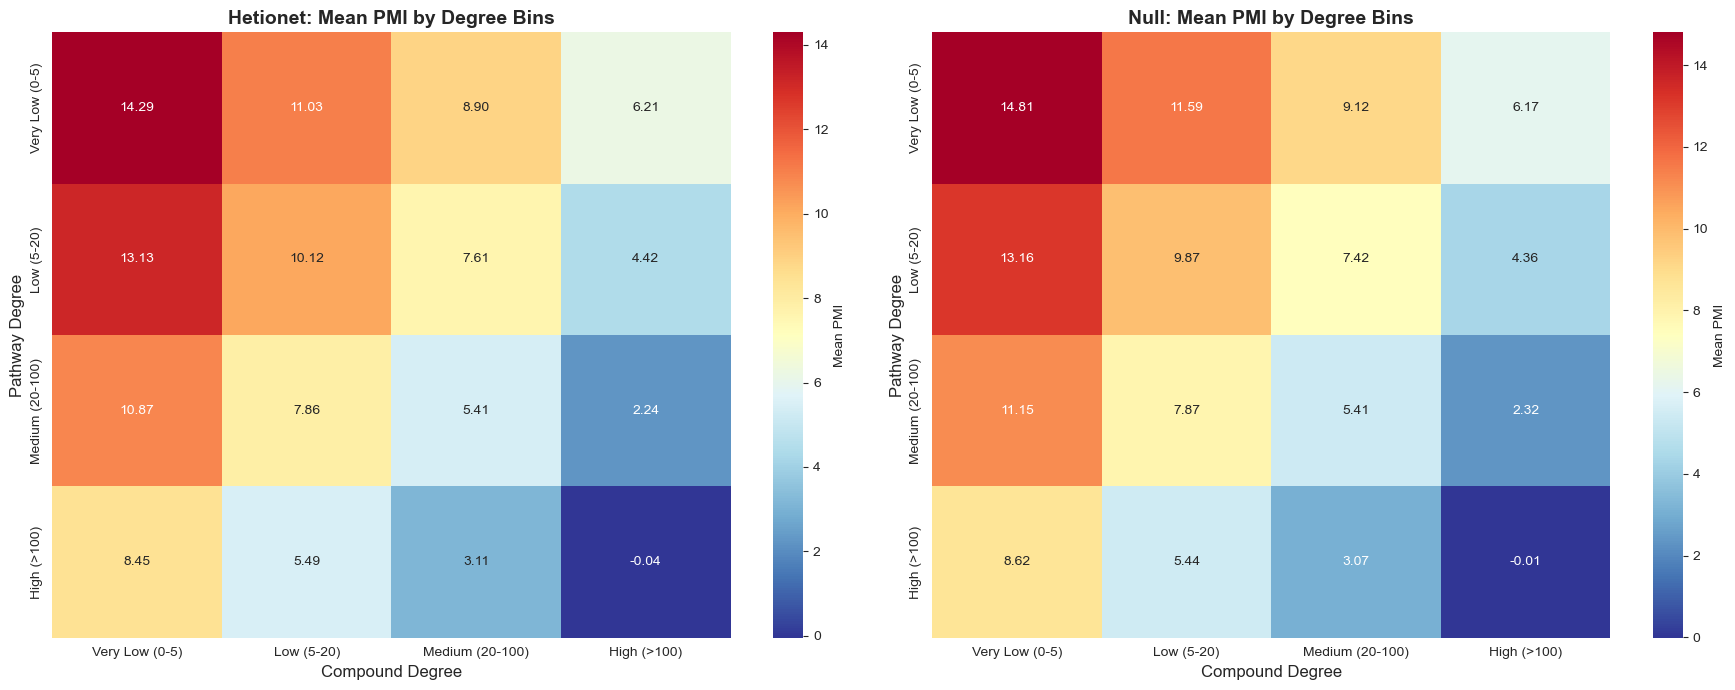


Saved heatmap to: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/metapath_CbGpPW_pmi_heatmap.png


In [11]:
# Create 2D heatmap: PMI by (compound_degree, pathway_degree)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Hetionet heatmap
ax = axes[0]
het_pivot = hetionet_results.pivot_table(
    values='pmi', 
    index='pathway_degree_bin', 
    columns='compound_degree_bin',
    aggfunc='mean'
)
sns.heatmap(het_pivot, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=ax, cbar_kws={'label': 'Mean PMI'})
ax.set_title('Hetionet: Mean PMI by Degree Bins', fontsize=14, fontweight='bold')
ax.set_xlabel('Compound Degree', fontsize=12)
ax.set_ylabel('Pathway Degree', fontsize=12)

# Null heatmap
ax = axes[1]
null_pivot = perm_df.pivot_table(
    values='pmi', 
    index='pathway_degree_bin', 
    columns='compound_degree_bin',
    aggfunc='mean'
)
sns.heatmap(null_pivot, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=ax, cbar_kws={'label': 'Mean PMI'})
ax.set_title('Null: Mean PMI by Degree Bins', fontsize=14, fontweight='bold')
ax.set_xlabel('Compound Degree', fontsize=12)
ax.set_ylabel('Pathway Degree', fontsize=12)

plt.tight_layout()
plt.savefig(results_dir / f'metapath_{metapath_name}_pmi_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved heatmap to: {results_dir / f'metapath_{metapath_name}_pmi_heatmap.png'}")

## Save Results

In [12]:
# Save detailed results
hetionet_results.to_csv(results_dir / f'metapath_{metapath_name}_hetionet_degree_results.csv', index=False)
perm_df.to_csv(results_dir / f'metapath_{metapath_name}_null_degree_results.csv', index=False)

# Save summary
summary = {
    'metapath': metapath_name,
    'hetionet_mean_pmi': het_pmi.mean(),
    'hetionet_median_pmi': np.median(het_pmi),
    'hetionet_std_pmi': het_pmi.std(),
    'null_mean_pmi': null_pmi.mean(),
    'null_median_pmi': np.median(null_pmi),
    'null_std_pmi': null_pmi.std(),
    'difference_mean_pmi': het_pmi.mean() - null_pmi.mean(),
    'mann_whitney_u': u_stat,
    'mann_whitney_p': u_pval,
    't_statistic': t_stat,
    't_test_p': t_pval,
    'hetionet_correlation': het_corr,
    'null_mean_correlation': np.mean(null_corrs),
    'null_std_correlation': np.std(null_corrs)
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(results_dir / f'metapath_{metapath_name}_degree_conditioned_summary.csv', index=False)

print(f"\nResults saved:")
print(f"  - {results_dir / f'metapath_{metapath_name}_hetionet_degree_results.csv'}")
print(f"  - {results_dir / f'metapath_{metapath_name}_null_degree_results.csv'}")
print(f"  - {results_dir / f'metapath_{metapath_name}_degree_conditioned_summary.csv'}")


Results saved:
  - /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/metapath_CbGpPW_hetionet_degree_results.csv
  - /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/metapath_CbGpPW_null_degree_results.csv
  - /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/metapath_CbGpPW_degree_conditioned_summary.csv


## Conclusions

In [13]:
print("\n" + "="*80)
print("CONCLUSIONS: DEGREE-CONDITIONED COMPOSITIONALITY")
print("="*80)

print(f"\n1. OVERALL COMPOSITIONALITY:")
print(f"   Hetionet mean PMI: {het_pmi.mean():.4f}")
print(f"   Null mean PMI:     {null_pmi.mean():.4f}")
print(f"   Difference:        {het_pmi.mean() - null_pmi.mean():+.4f}")

if u_pval < 0.001:
    if het_pmi.mean() > null_pmi.mean():
        print(f"\n   ✓ HETIONET IS MORE CONDITIONAL (p < 0.001)")
        print(f"     → Biological dependencies create additional conditional structure")
        print(f"     → Degree-preserving randomization breaks these dependencies")
        print(f"     → PMI in Hetionet reflects REAL biological relationships")
    else:
        print(f"\n   ✗ NULL IS MORE CONDITIONAL (p < 0.001)")
        print(f"     → Degree structure alone creates conditional dependencies")
        print(f"     → Need degree-aware null model")
else:
    print(f"\n   → NO SIGNIFICANT DIFFERENCE (p={u_pval:.3f})")
    print(f"     → Conditional structure is primarily degree-driven")

print(f"\n2. DEGREE STRATIFICATION:")
print(f"   [See degree-stratified comparison above]")

print(f"\n3. MODEL FIT:")
print(f"   Hetionet correlation: {het_corr:.4f}")
print(f"   Null mean correlation: {np.mean(null_corrs):.4f} ± {np.std(null_corrs):.4f}")

if het_corr < np.mean(null_corrs) - 2*np.std(null_corrs):
    print(f"\n   ✓ HETIONET IS SIGNIFICANTLY LESS COMPOSITIONAL")
    print(f"     → Biological structure violates compositional assumption more than null")
elif abs(het_corr - np.mean(null_corrs)) < np.std(null_corrs):
    print(f"\n   → HETIONET AND NULL HAVE SIMILAR COMPOSITIONALITY")
    print(f"     → Degree structure is the main driver")

print(f"\n4. RECOMMENDATIONS:")
if het_pmi.mean() > null_pmi.mean() + 1.0 and u_pval < 0.001:
    print(f"   → Use CONDITIONAL models for Hetionet metapaths")
    print(f"   → Biological dependencies are real and significant")
    print(f"   → Analytical prior (compositional) is insufficient")
    print(f"   → Consider learned/empirical priors that capture dependencies")
elif abs(het_pmi.mean() - null_pmi.mean()) < 0.5:
    print(f"   → DEGREE-AWARE compositional models may suffice")
    print(f"   → PMI is primarily driven by degree heterogeneity")
    print(f"   → Stratify by degrees and use compositional within strata")
else:
    print(f"   → MODERATE biological signal detected")
    print(f"   → Hybrid approach: compositional baseline + biological corrections")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")


CONCLUSIONS: DEGREE-CONDITIONED COMPOSITIONALITY

1. OVERALL COMPOSITIONALITY:
   Hetionet mean PMI: 7.1106
   Null mean PMI:     7.1331
   Difference:        -0.0225

   → NO SIGNIFICANT DIFFERENCE (p=0.219)
     → Conditional structure is primarily degree-driven

2. DEGREE STRATIFICATION:
   [See degree-stratified comparison above]

3. MODEL FIT:
   Hetionet correlation: 0.0572
   Null mean correlation: 0.0608 ± 0.0122

   → HETIONET AND NULL HAVE SIMILAR COMPOSITIONALITY
     → Degree structure is the main driver

4. RECOMMENDATIONS:
   → DEGREE-AWARE compositional models may suffice
   → PMI is primarily driven by degree heterogeneity
   → Stratify by degrees and use compositional within strata

ANALYSIS COMPLETE
